# Trend Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import curve_fit

## Data Cleaning and Preprocessing

In [2]:
# Preliminary data inspection
df = pd.read_csv('./slam_articles_with_country.csv')
# Handle missing values if any
df.dropna(subset=['year', 'country', 'is-referenced-by-count'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12218 entries, 0 to 46930
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   12214 non-null  object 
 1   DOI                     12218 non-null  object 
 2   publisher               12218 non-null  object 
 3   publisher_location      3827 non-null   object 
 4   year                    12218 non-null  int64  
 5   type                    12216 non-null  object 
 6   reference-count         12218 non-null  float64
 7   is-referenced-by-count  12218 non-null  float64
 8   authors                 12135 non-null  object 
 9   publisher_affiliation   8137 non-null   object 
 10  country                 12218 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 1.1+ MB


In [3]:
df.describe()

,year,reference-count,is-referenced-by-count
count,12218.000000,12218.000000,12218.000000
mean,2018.482567,23.222377,8.354559
std,5.174382,25.646633,32.364268
min,2002.000000,0.000000,0.000000
25%,2015.000000,4.000000,0.000000
50%,2021.000000,17.000000,1.000000
75%,2023.000000,35.000000,5.000000
max,2024.000000,715.000000,1349.000000


## Step 1: Time Series Analysis (Quantitative Growth in SLAM Research)

### Lets analize China vs. Rest of the World

<Figure size 1000x600 with 0 Axes>

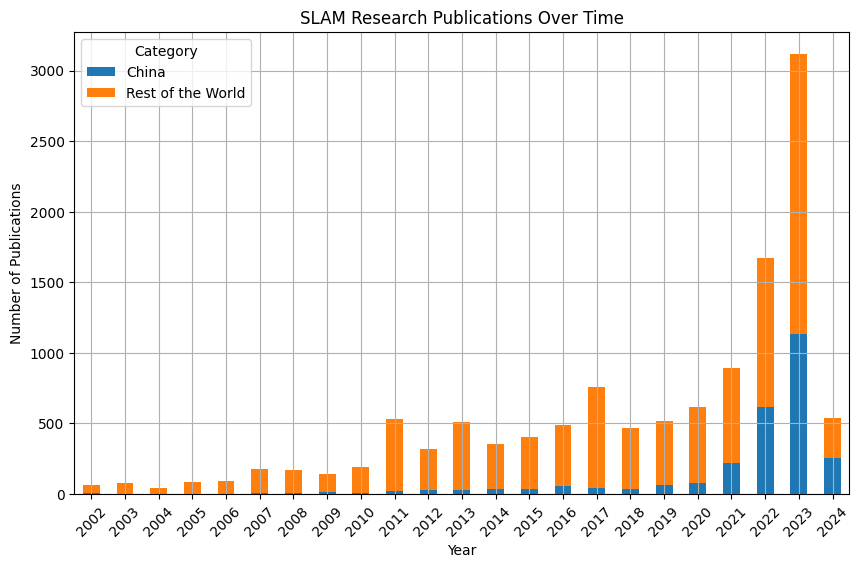

In [4]:
# Categorize articles by country (China vs. Rest of the World)
df['category'] = df['country'].apply(lambda x: 'China' if x == 'China' else 'Rest of the World')
pubs_by_year_country = df.groupby(['year', 'category']).size().unstack(fill_value=0)

# Show the plot
plt.figure(figsize=(10, 6))
# pubs_by_year_country.plot(kind='line')
pubs_by_year_country.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('SLAM Research Publications Over Time')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Number of Publications')
plt.legend(title='Category')
plt.grid(True)
plt.show()

### Analyzing Exponential Growth and Linear Trends Over Time

We can see that our data shows both an exponential and a linear pattern. To find the best-fit parameters for the function, we will use a combined model.

In [5]:
# Define the model functions
def linear_model(x, a, b):
    return a * x + b

def exponential_model(x, a, b):
    return a * np.exp(b * x)

def combined_model(x, a, b, c, d):
    return exponential_model(x, a, b) + linear_model(x, c, d)

china_data, rest_data = pubs_by_year_country.values[:-1].T # drop the last year
time_steps = np.arange(len(china_data))

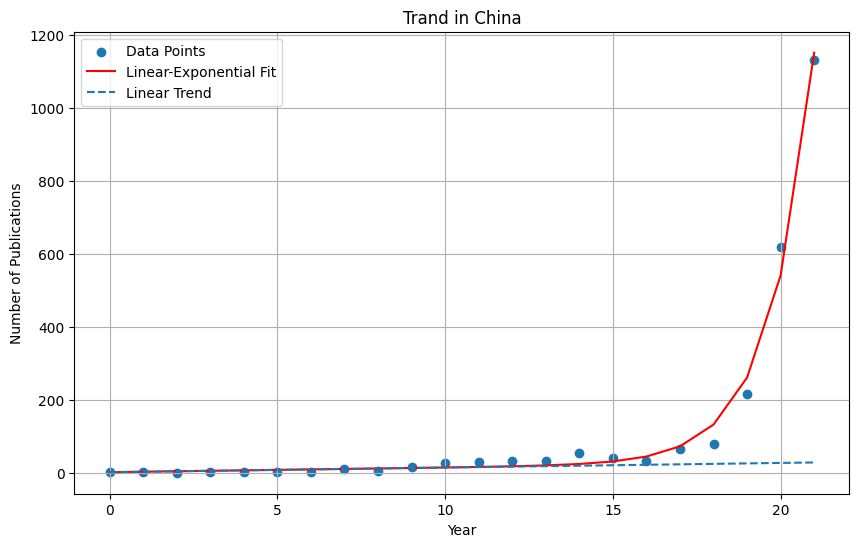

In [6]:
china_params, china_cov = curve_fit(combined_model, time_steps, china_data)

plt.figure(figsize=(10, 6))
plt.scatter(time_steps, china_data, label='Data Points')
plt.plot(time_steps, combined_model(time_steps, *china_params), label=f'Linear-Exponential Fit', color='red')
plt.plot(time_steps, linear_model(time_steps, *china_params[-2:]), label=f'Linear Trend', linestyle='--')
plt.title('Trand in China')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.legend()
plt.show()

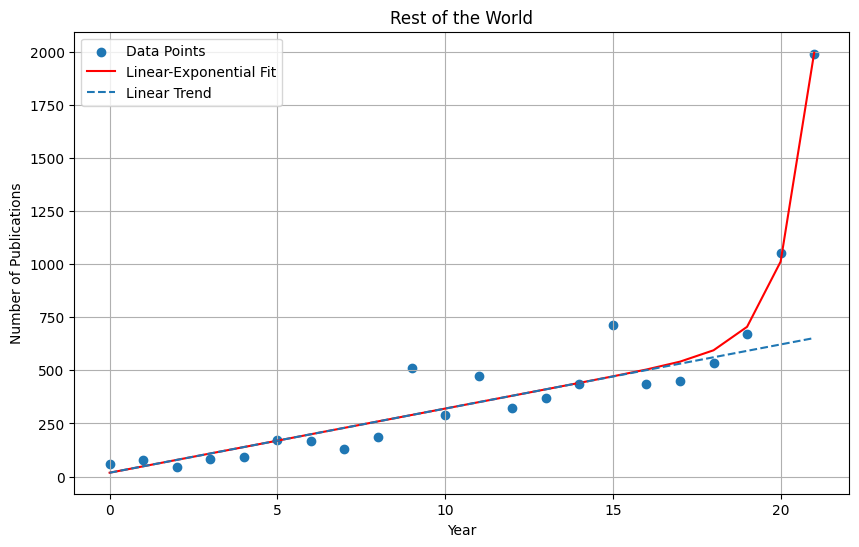

In [7]:
rest_params, rest_cov = curve_fit(combined_model, time_steps, rest_data)

plt.figure(figsize=(10, 6))
plt.scatter(time_steps, rest_data, label='Data Points')
plt.plot(time_steps, combined_model(time_steps, *rest_params), label=f'Linear-Exponential Fit', color='red')
plt.plot(time_steps, linear_model(time_steps, *rest_params[-2:]), label=f'Linear Trend', linestyle='--')
plt.title('Rest of the World')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

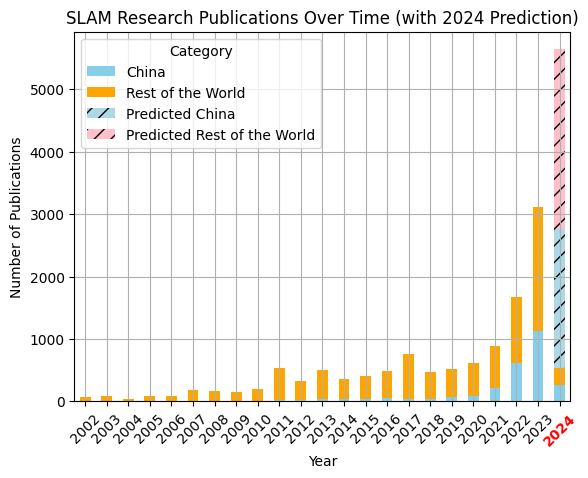

In [8]:
# # Categorize articles by country (China vs. Rest of the World)
data = pubs_by_year_country.copy()
# Adding new categories for predictions
data.loc[2024, 'Predicted China'] = combined_model(len(time_steps), *china_params) - data['China'].iloc[-1]
data.loc[2024, 'Predicted Rest of the World'] = combined_model(len(time_steps)-0.5, *rest_params) - data['Rest of the World'].iloc[-1]

# Plotting actual data
plt.figure(figsize=(12, 8))
data.plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'lightblue', 'pink'])

bars = plt.gca().patches
n = int(len(bars) / 2)
hatches = [''] * n +  ['//'] * n
for bar, hatch in zip(bars, hatches):  # loop over bars and hatches to set hatches in correct order
    bar.set_hatch(hatch)
    
plt.title('SLAM Research Publications Over Time (with 2024 Prediction)')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.ylabel('Number of Publications')
plt.legend(title='Category', loc='upper left')
plt.grid(True)
# Highlight the prediction part
plt.gca().get_xticklabels()[-1].set_color('red')
plt.gca().get_xticklabels()[-1].set_fontweight('bold')
plt.show()

### Copare by country

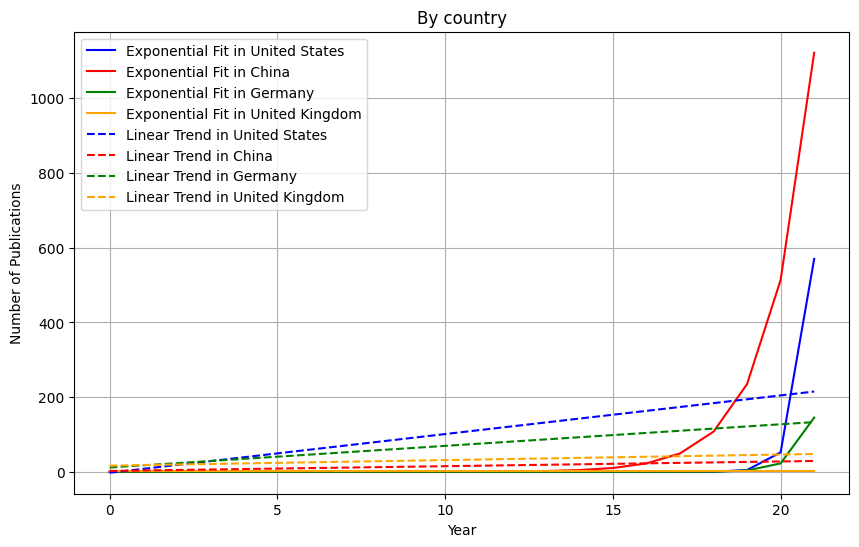

In [9]:
# Count publications by year and country
pubs_by_year_country = df.groupby(['year', 'country']).size().unstack(fill_value=0)
total_pubs_by_country = pubs_by_year_country.sum(axis=0).sort_values(ascending=False)

# Select top N countries for analysis
top_countries = total_pubs_by_country.iloc[:4].index.tolist()

def plot_country_trends(country, plot = True):
    # Extract data for the selected country
    country_data = pubs_by_year_country[country].values[:-1]
    time_steps = np.arange(len(country_data))
    params, _ = curve_fit(combined_model, time_steps, country_data, [1, 0.1, 1, 0], maxfev = 10000)

    # Plotting
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(time_steps, country_data, label='Data Points')
        plt.plot(time_steps, combined_model(time_steps, *params), label='Linear-Exponential Fit', color='red')
        plt.plot(time_steps, linear_model(time_steps, *params[-2:]), label='Linear Trend', linestyle='--')
        plt.title(f'Trend in {country}')
        plt.xlabel('Year')
        plt.ylabel('Number of Publications')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    return params

# Plot trends for top countries
countries_params = {}
for country in top_countries:
    try:
        countries_params[country] = plot_country_trends(country, False)
    except:
        pass

plt.figure(figsize=(10, 6))
colors = ['b','r','g','orange']
for i, (country, params) in enumerate(countries_params.items()):
    plt.plot(time_steps, exponential_model(time_steps, *params[:2]), label=f'Exponential Fit in {country}', c=colors[i%len(colors)])
for i, (country, params) in enumerate(countries_params.items()):
    plt.plot(time_steps, linear_model(time_steps, *params[-2:]), label=f'Linear Trend in {country}', linestyle='--', c=colors[i%len(colors)])

plt.title('By country')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.legend()
plt.show()

## Concludion

Our comprehensive analysis of the growth patterns in SLAM research publications across different regions, with a keen focus on China and comparisons with the three other countries contributing significantly to the field, has yielded insightful observations. Here's a summary of our key findings:

Rapid Acceleration in SLAM Research: Across the board, the SLAM research domain is experiencing a robust upward trajectory. The data indicates a widespread increase in the number of articles published over the last decade, suggesting a growing global interest and investment in SLAM technologies.

Distinctive Growth Pattern of China: Among the four leading countries in SLAM research, China stands out for its unique growth pattern. The analysis reveals that China's SLAM research has the smallest linear component coupled with the largest exponential component. This pattern indicates that China, despite its relatively late surge in activity within this domain, is now experiencing the most rapid growth. This acceleration suggests a strategic and substantial investment in SLAM research and development, positioning China as a burgeoning epicenter for SLAM innovation.

Global Contributions and Comparative Analysis: While China demonstrates the most pronounced exponential growth in SLAM research, the contributions from other leading countries remain substantial, showcasing a diversified advancement in the field. The linear and exponential modeling of publication trends in these countries reflects a more matured phase of steady research output and possibly a saturation point in the volume of new publications.

**Implications and Future Directions:** The distinct growth trajectory of China in SLAM research highlights a pivotal shift in the global landscape of technological advancements in this area. For policymakers, educators, and researchers, understanding these dynamics is crucial for fostering collaborations, directing funding, and prioritizing research agendas. Future research should explore the qualitative aspects of these publications, such as citation impact, to further elucidate the global standing and influence of China's contributions to SLAM research.

In conclusion, our study underscores the dynamic nature of SLAM research globally, with China rapidly emerging as a leading force. This trend not only enriches the global research ecosystem but also sets the stage for innovative breakthroughs and applications in SLAM technologies. As the field continues to evolve, monitoring these trends will be paramount in understanding the shifting centers of research excellence and their implications for global technological advancements.
